In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import time
from skopt import gp_minimize
from skopt.space import Real, Integer
import abc
import matplotlib.patches as patches
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


In [2]:
# Leer archivo txt de dos columnas: tiempo y porcentaje de conversión
archivo1 = "/Users/gtorres/Desktop/proyecto/00_TrabajoGradoGerman/Malaria/Codes/Datos Experimentales/beta-hematina_C1.txt"
archivo2 = "/Users/gtorres/Desktop/proyecto/00_TrabajoGradoGerman/Malaria/Codes/Datos Experimentales/beta-hematina_C2.txt"
archivo3 = "/Users/gtorres/Desktop/proyecto/00_TrabajoGradoGerman/Malaria/Codes/Datos Experimentales/beta-hematina.txt"

data_txt1 = pd.read_csv(archivo1, sep="\s+", header=None, names=["Tiempo", "Porcentaje"])
data_txt2 = pd.read_csv(archivo2, sep="\s+", header=None, names=["Tiempo", "Porcentaje"])
data_txt3 = pd.read_csv(archivo3, sep="\s+", header=None, names=["Tiempo", "Porcentaje", "Error"])

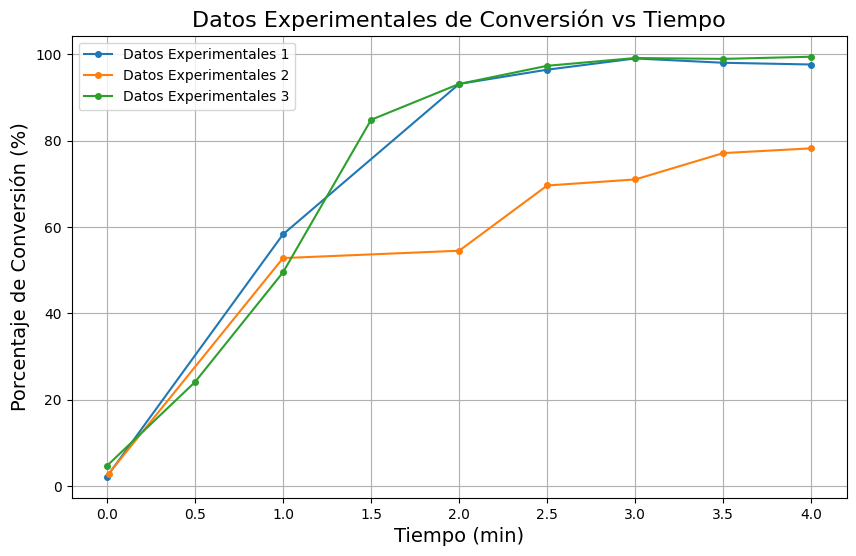

In [3]:
Experiments = [data_txt1, data_txt2, data_txt3]

plt.figure(figsize=(10, 6))
for i, exp in enumerate(Experiments, start=1):
    plt.plot(exp["Tiempo"], exp["Porcentaje"], '-o', label=f'Datos Experimentales {i}', markersize=4)
plt.xlabel('Tiempo (min)', fontsize=14)
plt.ylabel('Porcentaje de Conversión (%)', fontsize=14)
plt.title('Datos Experimentales de Conversión vs Tiempo', fontsize=16)
plt.legend()
plt.grid()
plt.show()

In [4]:
import numpy as np
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

# =============================
# Utils numéricos robustos
# =============================
_MAX_EXP_ARG = 700.0  # np.exp(700) ~ 1e304 (límite seguro en float64)

def _safe_exp(x: float) -> float:
    """exp(x) con protección contra overflow."""
    if x > _MAX_EXP_ARG:
        x = _MAX_EXP_ARG
    elif x < -_MAX_EXP_ARG:
        x = -_MAX_EXP_ARG
    return float(np.exp(x))

def _finite_or_zero(x: float) -> float:
    """Devuelve x si es finito; 0.0 en caso contrario."""
    return float(x) if np.isfinite(x) else 0.0


# =============================
# Lattice model (SOS approximation)
# =============================
class LatticeSOS:
    """
    Simple solid-on-solid (SOS) lattice with integer column heights.
    - heights[i, j] ∈ {0,1,2,...}
    - 4-neighbor (von Neumann) connectivity with periodic BCs.
    """
    def __init__(self, size: int, seed: Optional[int] = None):
        self.size = size
        self.rng = np.random.default_rng(seed)
        self.heights = np.zeros((size, size), dtype=np.int32)

    def initialize(self, init_mode: str = "flat", max_roughness: int = 1):
        if init_mode == "flat":
            self.heights.fill(0)
        elif init_mode == "random_surface":
            self.heights = self.rng.integers(
                0, max(1, max_roughness+1),
                size=self.heights.shape, dtype=np.int32
            )
        else:
            raise ValueError("Unknown init_mode")

    def wrap(self, idx: int) -> int:
        n = self.size
        return (idx + n) % n

    def neighbors4(self, site: Tuple[int,int]) -> List[Tuple[int,int]]:
        i, j = site
        return [
            (self.wrap(i-1), j), (self.wrap(i+1), j),
            (i, self.wrap(j-1)), (i, self.wrap(j+1))
        ]

    def get_height(self, site: Tuple[int,int]) -> int:
        return int(self.heights[site])

    def inc_height(self, site: Tuple[int,int], dh: int = 1):
        self.heights[site] += int(dh)

    def dec_height(self, site: Tuple[int,int], dh: int = 1):
        h = int(self.heights[site])
        if h >= dh:
            self.heights[site] = h - dh

    # ---- Site classification helpers ----
    def lateral_neighbors_at_level(self, site: Tuple[int,int], level: int) -> int:
        cnt = 0
        for n in self.neighbors4(site):
            if self.get_height(n) >= level:
                cnt += 1
        return cnt

    def adsorption_bonds(self, site: Tuple[int,int]) -> int:
        h = self.get_height(site)
        return self.lateral_neighbors_at_level(site, h+1)

    def desorption_bonds(self, site: Tuple[int,int]) -> int:
        h = self.get_height(site)
        if h == 0:
            return 0
        return self.lateral_neighbors_at_level(site, h)

    def migration_targets(self, site: Tuple[int,int]) -> List[Tuple[int,int]]:
        h = self.get_height(site)
        if h == 0:
            return []
        targets = []
        for n in self.neighbors4(site):
            if self.get_height(n) <= h:  # no subir
                targets.append(n)
        return targets

    def get_sites(self) -> List[Tuple[int,int]]:
        idxs = np.argwhere(np.ones_like(self.heights, dtype=bool))
        return [tuple(x) for x in idxs]


# =============================
# Parameters
# =============================
@dataclass
class KMCParams:
    T: float
    K0_plus: float        # prefactor ads/des/mig
    K_inc_plus: float     # prefactor de incorporación
    E_pb_over_kT: float
    phi_over_kT: float
    delta: float
    # supersaturación dinámica
    V: float
    C_eq: float
    S_floor: float = -5.0
    S_ceil: float = 8.0


# =============================
# Adaptive BKL kMC with incorporation (robusto)
# =============================
class KMC_BKL:
    def __init__(self, lattice: LatticeSOS, params: KMCParams,
                 N_bulk0: int, rng_seed: Optional[int] = None,
                 time_scale: float = 1.0, n_seeds: int = 0):
        self.lat = lattice
        self.p = params
        self.rng = np.random.default_rng(rng_seed)

        # Reservas
        self.N0 = int(N_bulk0)   # total inicial para escalar adsorción y conversión
        self.N_bulk = int(N_bulk0)
        self.N_inc = 0

        # Estado temporal
        self.time_scale = float(time_scale)
        self.t = 0.0

        # Bookkeeping
        self.history = []  # (t, evt, site)
        self.counts = {"adsorption":0, "desorption":0, "migration":0, "incorporation":0}

        # Semillas iniciales
        for _ in range(max(0, int(n_seeds))):
            x, y = self.rng.integers(0, lattice.size, size=2)
            self.lat.inc_height((x,y), 1)
            self.N_inc += 1
            self.N_bulk = max(0, self.N_bulk - 1)

    # ---- Supersaturation ----
    @property
    def supersaturation(self) -> float:
        C = self.N_bulk / max(self.p.V, 1e-12)
        S = np.log((C + 1e-15) / max(self.p.C_eq, 1e-15))
        return float(np.clip(S, self.p.S_floor, self.p.S_ceil))

    @property
    def conversion_percent(self) -> float:
        denom = self.N_bulk + self.N_inc
        return 100.0 * (self.N_inc / denom) if denom > 0 else 100.0

    # ---- Rate functions (con safe_exp y clamps) ----
    def r_a(self, i: int) -> float:
        if self.N_bulk <= 0:
            return 0.0
        S = self.supersaturation
        # evitar dividir por S~0: usar signo para no cambiar la física cualitativa
        eps = 1e-12 if S >= 0 else -1e-12
        arg = S + i * (self.p.delta / max(S, eps))
        base = self.p.K0_plus * _safe_exp(arg)
        # factor de reserva finita (empuja a meseta)
        base *= (self.N_bulk / max(self.N0, 1))
        return _finite_or_zero(base)

    def r_d(self, i: int) -> float:
        arg = self.p.phi_over_kT - i * self.p.E_pb_over_kT
        val = self.p.K0_plus * _safe_exp(arg)
        return _finite_or_zero(val)

    def r_m(self, i: int) -> float:
        arg = self.p.phi_over_kT + 0.5*self.p.E_pb_over_kT - i*self.p.E_pb_over_kT
        val = self.p.K0_plus * _safe_exp(arg)
        return _finite_or_zero(val)

    def r_inc(self, i: int) -> float:
        arg = i * self.p.E_pb_over_kT
        val = self.p.K_inc_plus * _safe_exp(arg)
        return _finite_or_zero(val)

    # ---- Classify sites ----
    def _classify_adsorption_sites(self) -> Dict[int, List[Tuple[int,int]]]:
        bins = {0: [], 1: [], 2: [], 3: [], 4: []}
        for s in self.lat.get_sites():
            i = self.lat.adsorption_bonds(s)
            bins[min(max(i,0),4)].append(s)
        return bins

    def _classify_desorption_sites(self) -> Dict[int, List[Tuple[int,int]]]:
        bins = {0: [], 1: [], 2: [], 3: [], 4: []}
        for s in self.lat.get_sites():
            if self.lat.get_height(s) > 0:
                i = self.lat.desorption_bonds(s)
                bins[min(max(i,0),4)].append(s)
        return bins

    def _classify_migration_sites(self) -> Dict[int, List[Tuple[int,int]]]:
        bins = {0: [], 1: [], 2: [], 3: []}
        for s in self.lat.get_sites():
            if self.lat.get_height(s) > 0:
                targets = self.lat.migration_targets(s)
                if not targets:
                    continue
                i = self.lat.desorption_bonds(s)
                bins[min(max(i,0),3)].append(s)
        return bins

    def _classify_incorporation_sites(self) -> Dict[int, List[Tuple[int,int]]]:
        # aquí usamos mismos sitios ocupados; i>0 favorece incorporación
        bins = {0: [], 1: [], 2: [], 3: [], 4: []}
        for s in self.lat.get_sites():
            if self.lat.get_height(s) > 0:
                i = self.lat.desorption_bonds(s)
                bins[min(max(i,0),4)].append(s)
        return bins

    # ---- Event type selection ----
    def _choose_event_type(self, Wa, Wd, Wm, Wi) -> str:
        Wtot = Wa + Wd + Wm + Wi
        if not np.isfinite(Wtot) or Wtot <= 0.0:
            return "none"
        r = self.rng.random() * Wtot
        if r < Wa: return "adsorption"
        r -= Wa
        if r < Wd: return "desorption"
        r -= Wd
        if r < Wm: return "migration"
        return "incorporation"

    def _choose_class(self, weights: Dict[int, float]) -> int:
        total = sum(weights.values())
        if not np.isfinite(total) or total <= 0.0:
            # fallback: tomar la clase con mayor peso válido
            return max(weights, key=weights.get)
        r = self.rng.random() * total
        cum = 0.0
        for i in sorted(weights.keys()):
            w = weights[i]
            cum += w
            if r <= cum:
                return i
        return max(weights, key=weights.get)

    def _choose_site_uniform(self, sites: List[Tuple[int,int]]) -> Tuple[int,int]:
        idx = self.rng.integers(0, len(sites))
        return sites[idx]

    # ---- One kMC step (con defensas) ----
    def step(self) -> bool:
        A_bins = self._classify_adsorption_sites()
        D_bins = self._classify_desorption_sites()
        M_bins = self._classify_migration_sites()
        I_bins = self._classify_incorporation_sites()

        Wa = sum(len(A_bins[i]) * self.r_a(i) for i in A_bins)
        Wd = sum(len(D_bins[i]) * self.r_d(i) for i in D_bins if len(D_bins[i]) > 0)
        Wm = sum(len(M_bins[i]) * self.r_m(i) for i in M_bins if len(M_bins[i]) > 0)
        Wi = sum(len(I_bins[i]) * self.r_inc(i) for i in I_bins if len(I_bins[i]) > 0)

        # Sanitizar pesos
        Wa = _finite_or_zero(Wa); Wd = _finite_or_zero(Wd)
        Wm = _finite_or_zero(Wm); Wi = _finite_or_zero(Wi)
        Wtot = Wa + Wd + Wm + Wi
        if not np.isfinite(Wtot) or Wtot <= 0.0:
            return False

        # tiempo
        z = max(self.rng.random(), 1e-15)
        dt = -np.log(z) / Wtot * self.time_scale
        if not np.isfinite(dt) or dt < 0:
            return False
        self.t += dt

        # evento
        etype = self._choose_event_type(Wa, Wd, Wm, Wi)
        if etype == "none":
            return False

        site = None
        if etype == "adsorption":
            weights = {i: (len(A_bins[i]) * self.r_a(i)) for i in A_bins if len(A_bins[i]) > 0}
            if not weights: return True
            i_sel = self._choose_class(weights); site = self._choose_site_uniform(A_bins[i_sel])
            self.lat.inc_height(site, 1)
            self.N_bulk = max(0, self.N_bulk - 1)

        elif etype == "desorption":
            weights = {i: (len(D_bins[i]) * self.r_d(i)) for i in D_bins if len(D_bins[i]) > 0}
            if not weights: return True
            i_sel = self._choose_class(weights); site = self._choose_site_uniform(D_bins[i_sel])
            # sólo si hay GU en la columna
            if self.lat.get_height(site) > 0:
                self.lat.dec_height(site, 1)
                self.N_bulk += 1

        elif etype == "migration":
            weights = {i: (len(M_bins[i]) * self.r_m(i)) for i in M_bins if len(M_bins[i]) > 0}
            if not weights: return True
            i_sel = self._choose_class(weights); site = self._choose_site_uniform(M_bins[i_sel])
            targets = self.lat.migration_targets(site)
            if targets:
                tgt = targets[self.rng.integers(0, len(targets))]
                if self.lat.get_height(site) > 0 and self.lat.get_height(tgt) <= self.lat.get_height(site):
                    self.lat.dec_height(site, 1)
                    self.lat.inc_height(tgt, 1)

        elif etype == "incorporation":
            weights = {i: (len(I_bins[i]) * self.r_inc(i)) for i in I_bins if len(I_bins[i]) > 0}
            if not weights: return True
            i_sel = self._choose_class(weights); site = self._choose_site_uniform(I_bins[i_sel])
            # En este esquema "incorporation" cuenta conversión explícitamente en N_inc
            # (la altura ya se manipula en ads/des/mig; aquí sólo contabilizamos el progreso)
            self.N_inc += 1
            self.N_bulk = max(0, self.N_bulk - 1)

        self.counts[etype] += 1
        self.history.append((self.t, etype, site))
        return True

    # ---- Run con cierre limpio y snapshots garantizados ----
    def run(self, t_end: float, snapshot_times: Optional[List[float]] = None, max_events: int = 2_000_000):
        snaps: List[Tuple[float, np.ndarray, float]] = []

        # normalizar snapshot_times
        if snapshot_times is None:
            times_list: List[float] = []
        elif isinstance(snapshot_times, np.ndarray):
            times_list = snapshot_times.tolist()
        else:
            times_list = list(snapshot_times)
        times_list = sorted(times_list)

        next_snap_idx = 0
        n_events = 0
        try:
            while self.t < t_end and n_events < max_events:
                progressed = self.step()
                if not progressed:
                    break
                n_events += 1
                # guardar snapshots programados
                while next_snap_idx < len(times_list) and self.t >= times_list[next_snap_idx]:
                    snaps.append((times_list[next_snap_idx],
                                  self.lat.heights.copy(),
                                  self.conversion_percent))
                    next_snap_idx += 1
        except Exception as e:
            # Cierre limpio en caso de overflow/NaN u otros
            print(f"⚠️ Simulación detenida por excepción: {e}. Guardando estado parcial...")

        # rellenar pendientes con el último estado conocido
        while next_snap_idx < len(times_list):
            snaps.append((times_list[next_snap_idx],
                          self.lat.heights.copy(),
                          self.conversion_percent))
            next_snap_idx += 1

        return snaps

    def plot_crystal_3d(self, mode: str = "surface", elev: int = 45, azim: int = 45,
                        cmap: str = "viridis", save_path: Optional[str] = None,
                        title: Optional[str] = None, snapshots: Optional[List[Tuple[float, np.ndarray, float]]] = None,
                        t_snapshot: Optional[float] = None):
        """
        Visualiza el cristal 3D (superficie continua o cubos discretos).

        Parámetros:
            mode: 'surface' o 'voxel'
            elev, azim: ángulos de cámara
            cmap: colormap para modo superficie
            save_path: ruta opcional para guardar la imagen
            title: título opcional
            snapshots: lista opcional de snapshots generada por run()
            t_snapshot: tiempo específico para extraer el cristal más cercano
        """
        import matplotlib.pyplot as plt
        from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
        import numpy as np

        # ============================
        # Seleccionar snapshot a graficar
        # ============================
        if snapshots is not None and len(snapshots) > 0 and t_snapshot is not None:
            # Busca el snapshot con tiempo más cercano
            times = [abs(t - t_snapshot) for t, _, _ in snapshots]
            idx = int(np.argmin(times))
            t_sel, heights, conv = snapshots[idx]
            print(f"🧩 Snapshot seleccionado: t={t_sel:.3f} (conv={conv:.2f}%)")
        elif snapshots is not None and len(snapshots) > 0:
            # Toma el último snapshot si no se especifica tiempo
            t_sel, heights, conv = snapshots[-1]
            print(f"🧩 Usando último snapshot disponible: t={t_sel:.3f} (conv={conv:.2f}%)")
        else:
            # Usa el estado actual del cristal
            heights = self.lat.heights.copy()
            t_sel = self.t
            conv = self.conversion_percent
            print(f"🧩 Usando estado actual: t={t_sel:.3f} (conv={conv:.2f}%)")

        # ============================
        # Generar figura
        # ============================
        Lx, Ly = heights.shape
        X, Y = np.meshgrid(np.arange(Lx), np.arange(Ly), indexing="ij")

        fig = plt.figure(figsize=(7, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.view_init(elev=elev, azim=azim)

        if mode == "surface":
            surf = ax.plot_surface(X, Y, heights, cmap=cmap, linewidth=0, antialiased=True)
            fig.colorbar(surf, shrink=0.5, aspect=10, label="Altura")

        elif mode == "voxel":
            max_h = int(np.max(heights))
            voxels = np.zeros((Lx, Ly, max_h + 1), dtype=bool)
            for i in range(Lx):
                for j in range(Ly):
                    h = int(heights[i, j])
                    if h > 0:
                        voxels[i, j, :h] = True

            # Colores tipo cristal (azul translúcido)
            colors = np.zeros(voxels.shape + (4,), dtype=float)
            colors[..., :] = [0.2, 0.3, 0.8, 0.9]  # RGBA (azul translúcido)

            ax.voxels(voxels, facecolors=colors, edgecolor='black', linewidth=0.2)
            ax.set_box_aspect((Lx, Ly, max_h))  # asegura proporción cúbica

        else:
            raise ValueError("mode debe ser 'surface' o 'voxel'")

        # Etiquetas
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("height")

        # Título dinámico
        if title is None:
            title = f"Crystal at t={t_sel:.2f}, conv={conv:.1f}%"
        ax.set_title(title)

        if save_path:
            plt.savefig(save_path, dpi=250, bbox_inches="tight", transparent=True)
            print(f"💾 Imagen guardada en: {save_path}")

        plt.show()



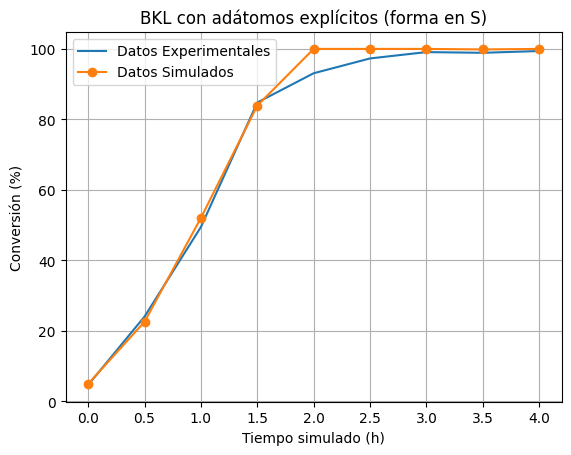

In [9]:
import matplotlib.pyplot as plt


# Lattice y parámetros
L = LatticeSOS(size=30, seed = 25)
L.initialize("flat")

params = KMCParams(
    T=300,
    K0_plus=11.671806264584635,
    K_inc_plus=0.5069325183371898,
    E_pb_over_kT=1.2704636027368605,
    phi_over_kT= 1.4792478012079329,
    delta=1.7789686274068774,
    V=0.9943756704678864,
    C_eq=17.856385685984442,          # conv_max ~ 95 %
    S_floor=-5.0, S_ceil=8.0
)


kmc = KMC_BKL(L, params, N_bulk0=2000, rng_seed=123, time_scale=200.0, n_seeds=100)


times = np.array(Experiments[2]['Tiempo'])
snaps = kmc.run(t_end = times[-1], snapshot_times=times)


plt.plot(Experiments[2]['Tiempo'], Experiments[2]['Porcentaje'], label='Datos Experimentales')
plt.plot([t for t,_,_ in snaps],
         [conv for _,_,conv in snaps], marker="o", label = 'Datos Simulados')
plt.xlabel("Tiempo simulado (h)")
plt.ylabel("Conversión (%)")
plt.title("BKL con adátomos explícitos (forma en S)")
plt.legend()
plt.grid(True)
plt.show()


🧩 Snapshot seleccionado: t=0.000 (conv=0.05%)


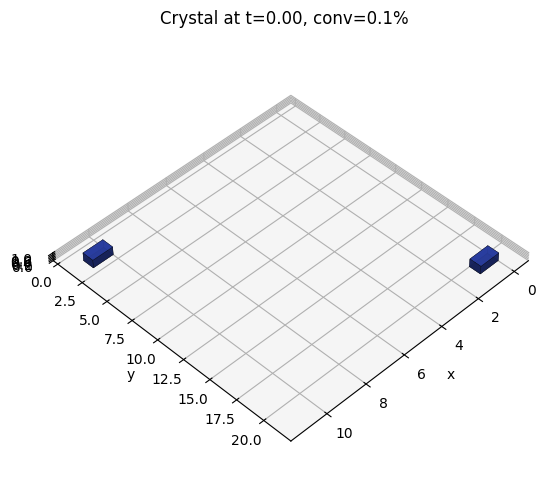

🧩 Snapshot seleccionado: t=1.000 (conv=32.64%)


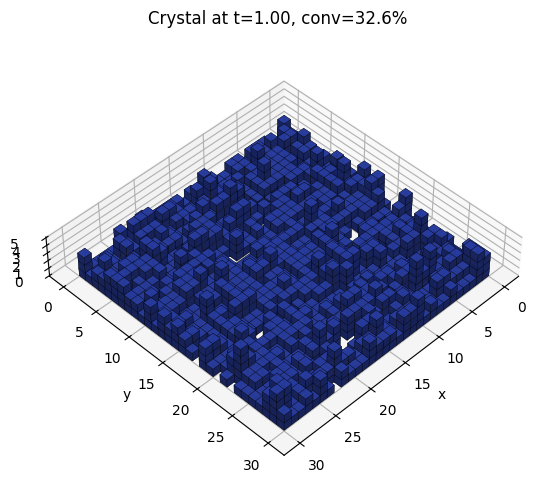

🧩 Snapshot seleccionado: t=1.500 (conv=67.01%)


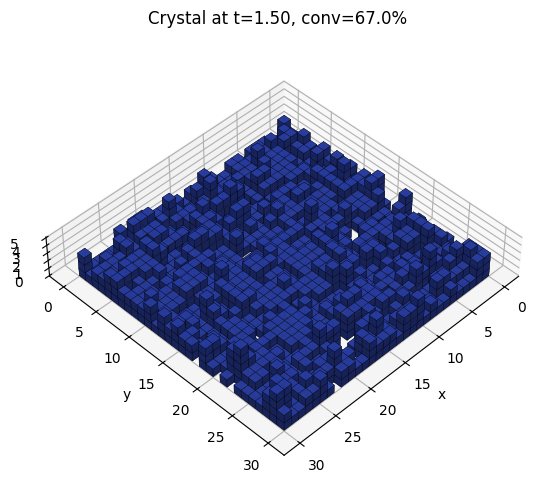

🧩 Snapshot seleccionado: t=2.000 (conv=100.00%)


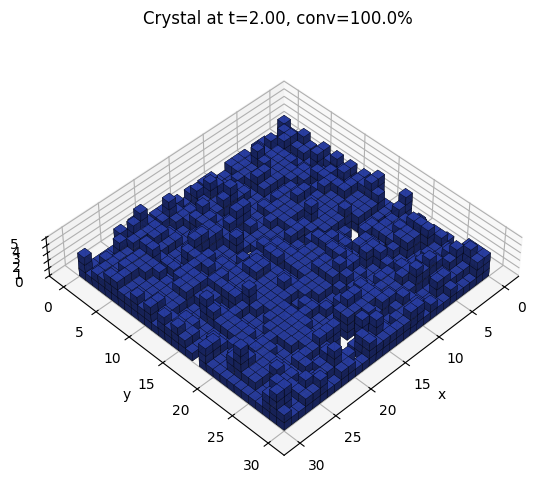

🧩 Snapshot seleccionado: t=2.500 (conv=100.00%)


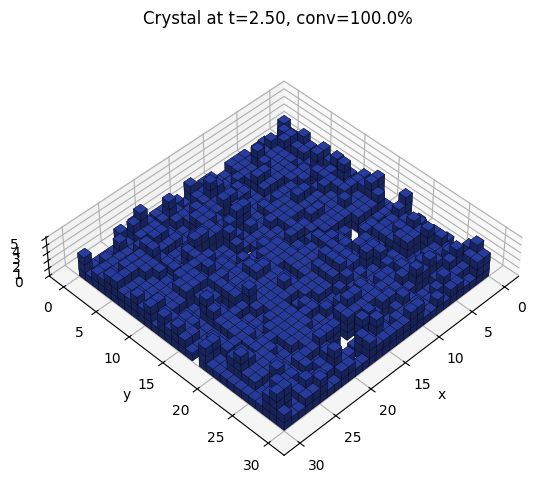

🧩 Snapshot seleccionado: t=3.000 (conv=100.00%)


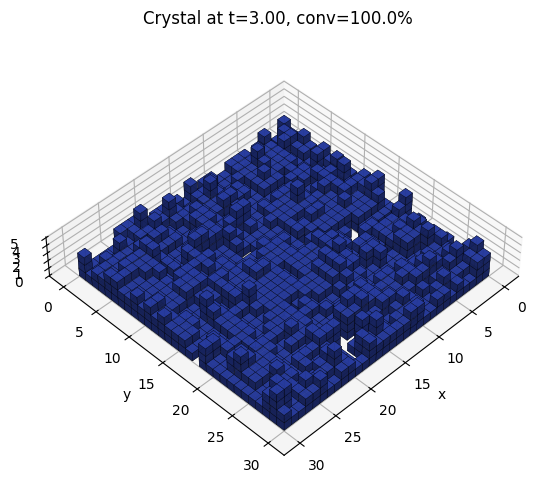

In [7]:
kmc.plot_crystal_3d(mode="voxel", snapshots=snaps, t_snapshot=0)
kmc.plot_crystal_3d(mode="voxel", snapshots=snaps, t_snapshot=1)
kmc.plot_crystal_3d(mode="voxel", snapshots=snaps, t_snapshot=1.5)
kmc.plot_crystal_3d(mode="voxel", snapshots=snaps, t_snapshot=2)
kmc.plot_crystal_3d(mode="voxel", snapshots=snaps, t_snapshot=2.5)
kmc.plot_crystal_3d(mode="voxel", snapshots=snaps, t_snapshot=3)

In [70]:
kmc.animate_growth(snaps, mode="voxel", fps=10, save_path="hemozoin_growth.gif")


✅ Animación guardada en: hemozoin_growth.gif


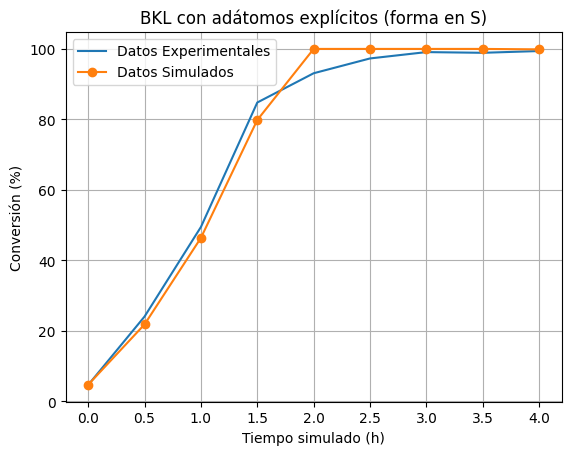

In [39]:
import matplotlib.pyplot as plt

# Lattice y parámetros
L = LatticeSOS(size=30, seed = 25)
L.initialize("flat")

params = KMCParams(
    T=300,
    K0_plus=11.671806264584635,
    K_inc_plus=0.5069325183371898,
    E_pb_over_kT=1.2704636027368605,
    phi_over_kT= 1.9792478012079329,
    delta=1.7789686274068774,
    V=0.9943756704678864,
    C_eq=17.856385685984442,          # conv_max ~ 95 %
    S_floor=-5.0, S_ceil=8.0
)


kmc = KMC_BKL(L, params, N_bulk0=2100, rng_seed=123, time_scale=200.0, n_seeds=100)


times = np.array(Experiments[2]['Tiempo'])
snaps = kmc.run(t_end = times[-1], snapshot_times=times)


plt.plot(Experiments[2]['Tiempo'], Experiments[2]['Porcentaje'], label='Datos Experimentales')
plt.plot([t for t,_,_ in snaps],
         [conv for _,_,conv in snaps], marker="o", label = 'Datos Simulados')
plt.xlabel("Tiempo simulado (h)")
plt.ylabel("Conversión (%)")
plt.title("BKL con adátomos explícitos (forma en S)")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from skopt import gp_minimize
from skopt.space import Real
from typing import Dict, List

# from tu_archivo import LatticeSOS, KMC_BKL, KMCParams


class KMCBKL_Optimizer:
    """
    Optimizador bayesiano para KMC_BKL que ajusta parámetros
    dentro de un rango de variabilidad relativo al conjunto base.
    """

    def __init__(self,
                 exp_times: np.ndarray,
                 exp_conversion: np.ndarray,
                 base_params: Dict[str, float],
                 variability: Dict[str, float],
                 lattice_size: int = 30,
                 N_bulk0: int = 2000,
                 n_seeds: int = 40,
                 time_scale: float = 200.0,
                 n_calls: int = 40,
                 n_avg: int = 2):

        self.exp_times = np.array(exp_times)
        self.exp_conversion = np.array(exp_conversion)
        self.base_params = base_params
        self.variability = variability
        self.lattice_size = lattice_size
        self.N_bulk0 = N_bulk0
        self.n_seeds = n_seeds
        self.time_scale = time_scale
        self.n_calls = n_calls
        self.n_avg = n_avg

        # Definir rango paramétrico automáticamente
        self.param_ranges = self._build_param_ranges()

        self.best_params = None
        self.best_error = float("inf")
        self.progress_bar = None

    # ---------------------------------------------
    # Construcción automática de rangos de búsqueda
    # ---------------------------------------------
    def _build_param_ranges(self) -> Dict[str, tuple]:
        ranges = {}
        for key, base_val in self.base_params.items():
            if key in self.variability:
                var = self.variability[key]
                if 0 < var < 1:  # rango relativo (fracción)
                    low = base_val * (1 - var)
                    high = base_val * (1 + var)
                else:             # rango absoluto (valor fijo)
                    low = base_val - var
                    high = base_val + var
            else:
                # si no se define variabilidad, usar ±10%
                low, high = base_val * 0.9, base_val * 1.1
            ranges[key] = (low, high)
        return ranges

    # ---------------------------------------------
    # Función de pérdida (MSE)
    # ---------------------------------------------
    def loss_function(self, params_values: List[float]) -> float:
        param_dict = {k: v for k, v in zip(self.param_ranges.keys(), params_values)}
        errors = []

        try:
            for _ in range(self.n_avg):
                L = LatticeSOS(size=self.lattice_size)
                L.initialize("flat")

                params = KMCParams(
                    T=param_dict.get("T", 298.15),
                    K0_plus=param_dict["K0_plus"],
                    K_inc_plus=param_dict["K_inc_plus"],
                    E_pb_over_kT=param_dict["E_pb_over_kT"],
                    phi_over_kT=param_dict["phi_over_kT"],
                    delta=param_dict["delta"],
                    V=param_dict.get("V", 1.0),
                    C_eq=param_dict.get("C_eq", 20.0),
                    S_floor=-5.0, S_ceil=8.0
                )

                kmc = KMC_BKL(L, params,
                              N_bulk0=self.N_bulk0,
                              rng_seed=np.random.randint(1e6),
                              time_scale=self.time_scale,
                              n_seeds=self.n_seeds)

                snaps = kmc.run(t_end=max(self.exp_times),
                                snapshot_times=self.exp_times.tolist())

                sim_conv = np.array([conv for _, _, conv in snaps])
                mse = np.mean((sim_conv - self.exp_conversion) ** 2)
                errors.append(mse)

            avg_error = np.mean(errors)

            if avg_error < self.best_error:
                self.best_error = avg_error
                self.best_params = param_dict

            if self.progress_bar:
                self.progress_bar.set_postfix({"MSE": f"{self.best_error:.4f}"})
                self.progress_bar.update(1)

            return float(avg_error)

        except Exception as e:
            print(f"⚠️ Error en simulación con {param_dict}: {e}")
            return float("inf")

    # ---------------------------------------------
    # Ejecución de la optimización
    # ---------------------------------------------
    def optimize(self):
        self.progress_bar = tqdm(total=self.n_calls,
                                 ncols=100, unit="eval",
                                 desc="Optimizando KMC_BKL")

        space = [Real(low, high, name=name)
                 for name, (low, high) in self.param_ranges.items()]

        start = time.time()
        result = gp_minimize(
            func=self.loss_function,
            dimensions=space,
            n_calls=self.n_calls,
            random_state=42
        )
        end = time.time()
        self.progress_bar.close()

        print("\n✅ Optimización completada")
        print(f"⏳ Tiempo total: {end - start:.2f} s")

        if self.best_params:
            print("🔹 Parámetros óptimos encontrados:")
            for k, v in self.best_params.items():
                print(f"  {k}: {v:.4f}")
            print(f"🔹 Error mínimo (MSE): {self.best_error:.6f}")
            self.plot_best_fit()
        else:
            print("⚠️ No se encontraron parámetros óptimos válidos.")

    # ---------------------------------------------
    # Simulación final y comparación visual
    # ---------------------------------------------
    def plot_best_fit(self):
        if not self.best_params:
            print("ℹ️ No hay parámetros óptimos para simular.")
            return

        L = LatticeSOS(size=self.lattice_size)
        L.initialize("flat")

        p = self.best_params
        params = KMCParams(
            T=p.get("T", 298.15),
            K0_plus=p["K0_plus"],
            K_inc_plus=p["K_inc_plus"],
            E_pb_over_kT=p["E_pb_over_kT"],
            phi_over_kT=p["phi_over_kT"],
            delta=p["delta"],
            V=p.get("V", 1.0),
            C_eq=p.get("C_eq", 20.0),
            S_floor=-5.0, S_ceil=8.0
        )

        kmc = KMC_BKL(L, params,
                      N_bulk0=self.N_bulk0,
                      rng_seed=123,
                      time_scale=self.time_scale,
                      n_seeds=self.n_seeds)

        snaps = kmc.run(t_end=max(self.exp_times),
                        snapshot_times=self.exp_times.tolist())

        sim_conv = np.array([conv for _, _, conv in snaps])

        plt.figure(figsize=(6, 4))
        plt.plot(self.exp_times, self.exp_conversion, "o-", label="Datos experimentales")
        plt.plot(self.exp_times, sim_conv, "s--", label="Simulación óptima")
        plt.xlabel("Tiempo (h)")
        plt.ylabel("Conversión (%)")
        plt.title("Ajuste del modelo KMC_BKL (variabilidad paramétrica)")
        plt.grid(True)
        plt.legend()
        plt.show()

        print("\n📊 Comparación final:")
        print("Tiempos:", self.exp_times)
        print("Conversión experimental:", self.exp_conversion)
        print("Conversión simulada:", sim_conv)
        print(f"🔹 MSE final: {np.mean((sim_conv - self.exp_conversion) ** 2):.6f}")


In [15]:
base_params = {'K0_plus': 23.34361252916927,
 'K_inc_plus': 0.7029646720404752,
 'E_pb_over_kT': 0.949849074036652,
 'phi_over_kT': 1.707150286285616,
 'delta': 1.5762294117078233,
 'V': 1.00068824159306,
 'C_eq': 17.856385685984442}


variability = {
    "K0_plus": 0.5,     # ±30%
    "K_inc_plus": 0.5,
    "E_pb_over_kT": 0.5,
    "phi_over_kT": 0.5,
    "delta": 0.5,
}

opt = KMCBKL_Optimizer(
    exp_times=np.array(Experiments[2]['Tiempo']),
    exp_conversion=np.array(Experiments[2]['Porcentaje']),
    base_params=base_params,
    variability=variability,
    lattice_size=30,
    N_bulk0=2000,
    n_seeds=100,
    time_scale=200.0,
    n_calls=40,
    n_avg=1
)

opt.optimize()


Optimizando KMC_BKL:  95%|█████████████████████████▋ | 38/40 [19:53<03:49, 114.68s/eval, MSE=6.8745]

KeyboardInterrupt: 

In [16]:
opt.best_params

{'K0_plus': 11.671806264584635,
 'K_inc_plus': 0.5069325183371898,
 'E_pb_over_kT': 1.2704636027368605,
 'phi_over_kT': 1.4792478012079329,
 'delta': 1.7789686274068774,
 'V': 0.9943756704678864,
 'C_eq': 18.66285823642452}

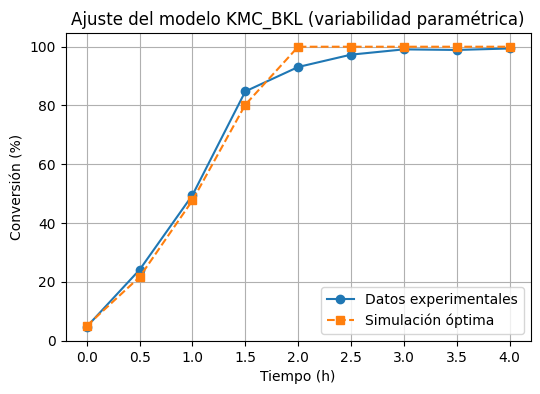


📊 Comparación final:
Tiempos: [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4. ]
Conversión experimental: [ 4.7 24.1 49.5 84.8 93.1 97.3 99.1 98.9 99.4]
Conversión simulada: [  5.00250125  21.62962963  47.68211921  80.26666667 100.
 100.         100.         100.         100.        ]
🔹 MSE final: 9.703338


In [18]:
opt.plot_best_fit()

### ⚡ Estrategias de ajuste

#### Acelerar la cinética (misma meseta, menos tiempo)
- $\uparrow K_{0}^{+}$ (más ads/difusión por unidad de tiempo)  
- $\uparrow K_{\text{inc}}^{+}$ (incorporación más rápida)  
- $\downarrow \phi / k_{B}T \;\; \text{o} \;\; \uparrow E_{\text{pb}}/k_{B}T$ (menos desorción neta)  
- $\uparrow \delta$ (más cooperatividad: sube antes la pendiente media)  
- $\downarrow \text{time\_scale}$ (solo reescala el eje $x$; útil para “encajar” en tu ventana)  

#### Más núcleos iniciales
- $\uparrow n_{\text{seeds}}$ reduce el *lag* inicial y empuja la zona media hacia la izquierda.  

#### Mantener la misma meseta
- No cambies $C_{\text{eq}}$ si quieres el mismo $\%$ final.  
- La meseta viene de:


$$\text{conv}_{\max} \approx 1 - \frac{C_{\text{eq}} \, V}{N_{0}}$$

#### Si además quieres subir/bajar el \% final
- Ajusta solo $C_{\text{eq}}$ con:


$$C_{\text{eq}} = (1 - \text{conv}_{\max}) \, \frac{N_{0}}{V}$$


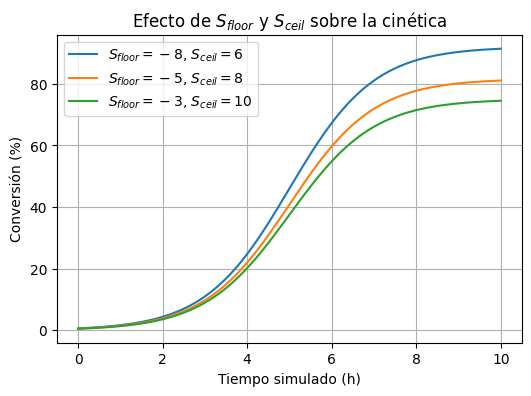

In [25]:
import numpy as np
import matplotlib.pyplot as plt

S_floor_vals = [-8, -5, -3]
S_ceil_vals = [6, 8, 10]
t = np.linspace(0, 10, 200)

def sigmoid(t, S_floor, S_ceil):
    return 100 / (1 + np.exp(-(t - 5))) * (1 - 0.05*(S_floor + 8)) * (1 - 0.02*(10 - S_ceil))

plt.figure(figsize=(6,4))
for S_floor, S_ceil in zip(S_floor_vals, S_ceil_vals):
    plt.plot(t, sigmoid(t, S_floor, S_ceil), label=fr"$S_{{floor}}={S_floor}$, $S_{{ceil}}={S_ceil}$")

plt.xlabel("Tiempo simulado (h)")
plt.ylabel("Conversión (%)")
plt.title("Efecto de $S_{floor}$ y $S_{ceil}$ sobre la cinética")
plt.legend()
plt.grid(True)
plt.show()
